In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import sys
sys.path.append('../python')
from functions import *
from models import *

import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-02-09 11:48:06.421249: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-09 11:48:06.438334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2022-02-09 11:48:06.438809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-09 11:48:06.440682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-09 11:48:06.442484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-09 11:48:06.442999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-0

# Preparation

## Load a file and label the stream stars

In [ ]:
column_names = ["μ_δ", "μ_α", "δ", "α", "color", "mag", "lon", "lat", "μ_loncoslat", "μ_lat"]
gd1_stars = np.load('../gaia_data/gd1/gd1_stars.npy')
filename = "./gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy"
df = pd.DataFrame(np.load(filename), columns = column_names)
is_stream, stream = FilterGD1(np.array(df), gd1_stars)

In [ ]:
plt.hist2d(df.μ_lat, df.μ_loncoslat, bins=np.linspace(-30,10,50));

In [ ]:
plt.hist2d(df.lon, df.lat, bins=100);

In [ ]:
plt.figure(dpi=100)
plt.scatter(df[is_stream].α, df[is_stream].δ)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in this Patch");

## Get GD1 stars from all patches

In [ ]:
patch_list = [
 # b = 33.7 
 './gaia_data/gd1/gaiascan_l195.0_b33.7_ra128.4_dec28.8.npy',
 './gaia_data/gd1/gaiascan_l210.0_b33.7_ra132.6_dec16.9.npy',
 './gaia_data/gd1/gaiascan_l225.0_b33.7_ra138.1_dec5.7.npy', 
 # b = 41.8 
 './gaia_data/gd1/gaiascan_l187.5_b41.8_ra136.5_dec36.1.npy',
 './gaia_data/gd1/gaiascan_l202.5_b41.8_ra138.8_dec25.1.npy',
 './gaia_data/gd1/gaiascan_l217.5_b41.8_ra142.7_dec14.5.npy', 
 # b = 50.2 
 './gaia_data/gd1/gaiascan_l99.0_b50.2_ra224.7_dec60.6.npy',
 './gaia_data/gd1/gaiascan_l117.0_b50.2_ra202.4_dec66.5.npy',
 './gaia_data/gd1/gaiascan_l135.0_b50.2_ra174.3_dec65.1.npy',
 './gaia_data/gd1/gaiascan_l153.0_b50.2_ra156.2_dec57.5.npy',
 './gaia_data/gd1/gaiascan_l171.0_b50.2_ra148.6_dec47.0.npy',
 './gaia_data/gd1/gaiascan_l189.0_b50.2_ra146.9_dec35.6.npy',
 './gaia_data/gd1/gaiascan_l207.0_b50.2_ra148.6_dec24.2.npy',
 # b = 58.4 
 './gaia_data/gd1/gaiascan_l101.2_b58.4_ra212.7_dec55.2.npy',
 './gaia_data/gd1/gaiascan_l123.8_b58.4_ra192.0_dec58.7.npy',
 './gaia_data/gd1/gaiascan_l146.2_b58.4_ra171.8_dec54.7.npy',
 './gaia_data/gd1/gaiascan_l168.8_b58.4_ra160.5_dec45.5.npy',
 './gaia_data/gd1/gaiascan_l191.2_b58.4_ra156.9_dec34.1.npy',
 # b = 66.4 
 './gaia_data/gd1/gaiascan_l105.0_b66.4_ra203.7_dec49.1.npy',
 './gaia_data/gd1/gaiascan_l135.0_b66.4_ra185.4_dec50.0.npy',
 './gaia_data/gd1/gaiascan_l165.0_b66.4_ra171.4_dec43.0.npy',    
]

In [ ]:
dfs = []

for file in tqdm(patch_list):
    df = pd.DataFrame(np.load(file), columns = column_names)
    is_stream, stream = FilterGD1(np.array(df), gd1_stars)
    df["stream"] = is_stream
    df["patch_id"] = patch_list.index(file)
    dfs.append(df)

In [ ]:
df_all = pd.concat([df for df in dfs])
df_all['α'] = df_all['α'].apply(lambda x: x if x > 100 else x + 360) # wrap around plot
df_all.to_hdf("gd1_allpatches.h5", key="df")

In [ ]:
gd1_stars_in_patches = pd.concat([df[df.stream] for df in dfs])

In [ ]:
plt.figure(dpi=150)
plt.scatter(gd1_stars_in_patches.α, gd1_stars_in_patches.δ, marker='.')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stars in All Patches");

That's a little funky, let's modify it:

In [ ]:
gd1_stars_in_patches['α_new'] = gd1_stars_in_patches['α'].apply(lambda x: x if x > 100 else x + 360)

In [ ]:
plt.figure(figsize=(12,3),dpi=150)
plt.scatter(gd1_stars_in_patches.α_new, gd1_stars_in_patches.δ, marker='.', c=gd1_stars_in_patches.μ_δ)
plt.colorbar(label=r"$\mu_\delta$")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$")
plt.title("GD1 Stream (21 patches)");

## Define a new, optimized tail patch

Load all the patches:

In [ ]:
df_all = pd.read_hdf("./gaia_data/gd1/gd1_allpatches.h5")

In [ ]:
visualize_stream(df_all)

Define a new, optimized patch for the tail & save it:

In [ ]:
# df = df_all[(df_all.α > 120) & (df_all.α < 140)] # select just the (left) tail area 
df = df_all[(df_all.α > 185) & (df_all.α < 230)] # select just the (right) tail area 
# df.α = df.α - df.α.mean()
# df.δ = df.δ - df.δ.mean()
df = df[(df.α - df.α.mean())**2 + (df.δ - df.δ.mean())**2 < 15**2]

In [ ]:
df

In [ ]:
df.to_hdf("./gaia_data/gd1_tail/gd1_tail_optimized_patch_left.h5", "df")

## Load the optimized patch & train:

In [ ]:
df = pd.read_hdf("./gaia_data/gd1_tail/gd1_tail_optimized_patch.h5", "df")

In [ ]:
visualize_stream(df)

In [ ]:
df_train = signal_sideband(df, stream="gd1_tail",
#                     Right tail patch
                    sb_min = -7, 
                    sr_min = -6, 
                    sr_max = -3.1,
                    sb_max = -3
                           
#                     sb_min = -4.5, 
#                     sr_min = -4, 
#                     sr_max = -3,
#                     sb_max = -2.5
                           
#                     sb_min = -10, 
#                     sr_min = -6, 
#                     sr_max = -1,
#                     sb_max = 1
                         
#                     # Left tail patch       
#                     sb_min = -15, 
#                     sr_min = -13.5, 
#                     sr_max = -11,
#                     sb_max = -10
                        )

Add sample weights to stream stars:

In [ ]:
stream_weight = 1

### Throughout signal & sideband regions
df_train["weight"] = np.where(df_train['stream'] == True, stream_weight, 1)

Train:

In [ ]:
df_train.weight.unique()

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
test = train(df_train,
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 128, 
      batch_size = 10000, 
      dropout = 0.2, 
      epochs = 2000,
      patience = 30)

## Load a pre-trained model on the tail

In [ ]:
test = pd.read_hdf("./trained_models/foundtail_size128_batch10000_epochs2000/df_test.h5")

In [ ]:
# visualize_stream(test)

In [ ]:
plot_results(test)

In [ ]:
top_stars = test.sort_values('nn_score',ascending=False)[:100]

In [ ]:
top_stars.keys()

In [ ]:
labeled_gd1 = top_stars[top_stars.stream]
unlabeled_gd1 = top_stars[top_stars.stream == False]

In [ ]:
best_unlabeled = unlabeled_gd1.sort_values('nn_score',ascending=False)[:10]

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(labeled_gd1.α, labeled_gd1.δ, label="Labeled GD1")
plt.scatter(unlabeled_gd1.α, unlabeled_gd1.δ, label="Unlabeled")
plt.legend()
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\delta$");

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(labeled_gd1.μ_α, labeled_gd1.μ_δ, label="Labeled GD1")
plt.scatter(unlabeled_gd1.μ_α, unlabeled_gd1.μ_δ, label="Unlabeled")
plt.legend()
plt.xlabel(r"$\mu_\alpha$")
plt.ylabel(r"$\mu_\delta$");

# Run on each of the 21 GD1 patches

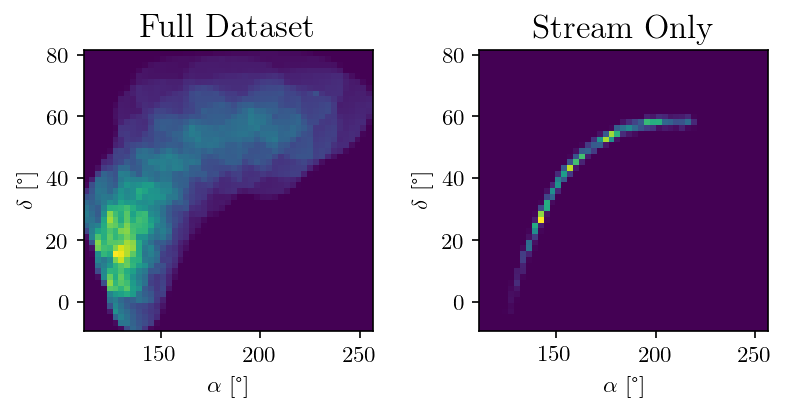

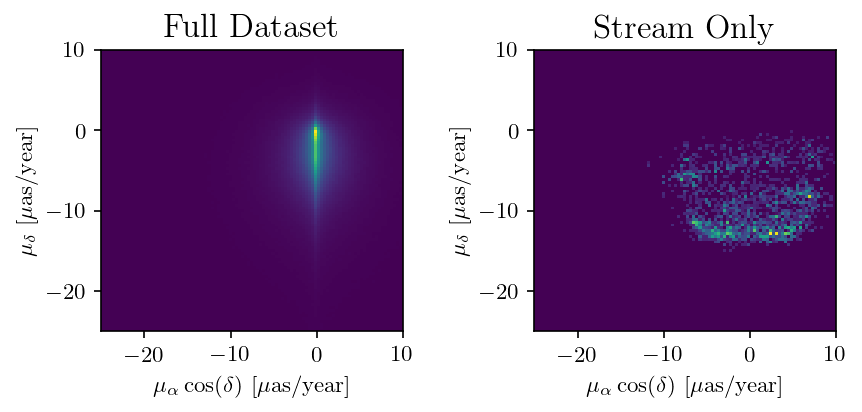

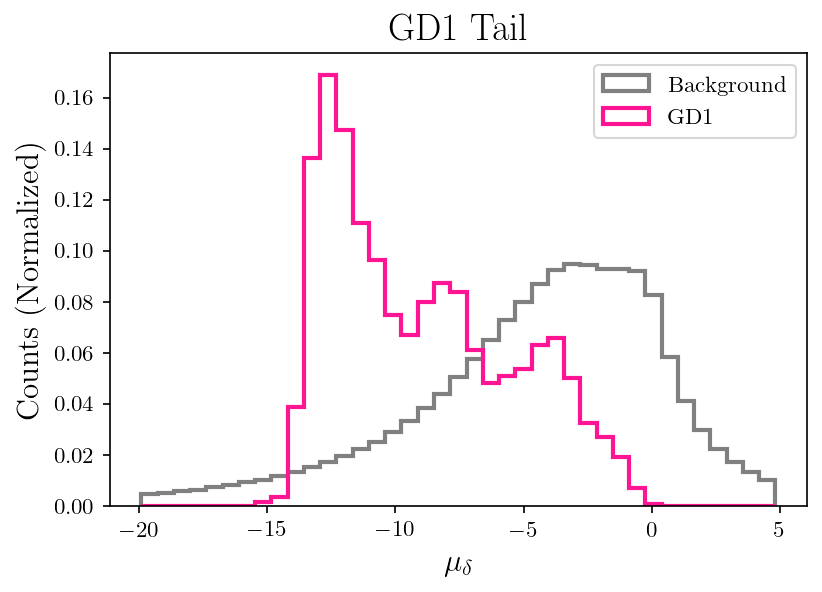

In [3]:
df_all = pd.read_hdf("../gaia_data/gd1/gd1_allpatches.h5")
visualize_stream(df_all)

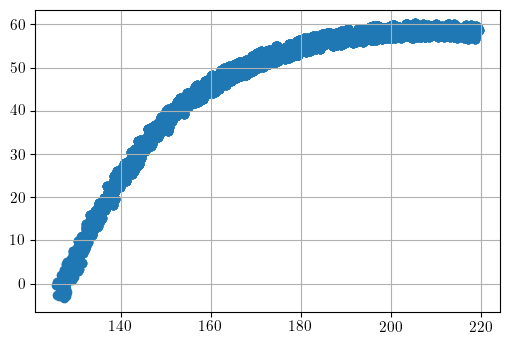

In [5]:
plt.scatter(df_all[df_all.stream].α, df_all[df_all.stream].δ)
plt.grid()

In [9]:
alphas = np.linspace(df_all[df_all.stream].α.min(), df_all[df_all.stream].α.max(), 3)
alphas

array([125.58813477, 172.60390472, 219.61967468])

In [10]:
for alpha in alphas: 
    print(df_all[(df_all.stream & (np.abs(df_all.α - alpha) < 5))].δ.mean())

3.7917955851537646
52.606458631830186
58.493264782813284


In [ ]:
id = 20
α_min = df_all[df_all.patch_id == id].α.min()
α_max = df_all[df_all.patch_id == id].α.max()
δ_min = df_all[df_all.patch_id == id].δ.min()
δ_max = df_all[df_all.patch_id == id].δ.max()

visualize_stream(df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                        (δ_min < df_all.δ) & (df_all.δ < δ_max)])

Hand-pick limits for each patch:

In [ ]:
limits = pd.DataFrame([
                  [0, -15, -13.5, -11, -10],
                  [1, -14, -13, -12, -11],
                  [2, -14, -13, -11.5, -10],
                  [3, -14, -13, -11, -10],
                  [4, -15, -14, -12, -11],
                  [5, -15, -14, -12, -11],
                  [6, -5, -4, -2.5, 2],
                  [7, -10, -9.5, -8, -7],
                  [8, -9, -8, -7, -6],
                  [9, -9, -8, -7, -6],
                  [10, -12.5, -12, -11, -10],
                  [11, -14, -13, -11, -10],
                  [12, -14, -13, -12, -11],
                  [13, -6, -5, -4, -2],
                  [14, -9, -8, -7, -6],
                  [15, -9, -8, -7, -6],
                  [16, -14, -13, -11, -10],
                  [17, -14, -13, -12, -11],
                  [18, -6, -5, -3, -2],
                  [19, -9, -8, -6, -5],
                  [20, -9, -8.5, -6, -5.5],
                  ],
                  columns=["patch_id","sb_min","sr_min","sr_max","sb_max"])

Run over each patch:

In [ ]:
target_stream = []
top_100_stars = []

## Scan over patches
for patch_id in tqdm(limits.patch_id.unique()):
    α_min = df_all[df_all.patch_id == patch_id].α.min()
    α_max = df_all[df_all.patch_id == patch_id].α.max()
    δ_min = df_all[df_all.patch_id == patch_id].δ.min()
    δ_max = df_all[df_all.patch_id == patch_id].δ.max()

    
    print("Delta alpha: {}".format(α_max-α_min))
    df = df_all[(α_min < df_all.α) & (df_all.α < α_max) & 
                (δ_min < df_all.δ) & (df_all.δ < δ_max)]
    
    if np.sum(df.stream)/len(df) < 0.0001: # skip patches with hardly any stream stars
        continue
    else:
        try: 
            plt.scatter(df[df.stream].α, df[df.stream].δ, alpha=0.1)
#             visualize_stream(df)
        except: 
            continue
#         target_stream.append(df[df.stream])  
#         df_train = signal_sideband(df,
#                         sb_min = float(limits[limits.patch_id == patch_id].sb_min),
#                         sr_min = float(limits[limits.patch_id == patch_id].sr_min),
#                         sr_max = float(limits[limits.patch_id == patch_id].sr_max),
#                         sb_max = float(limits[limits.patch_id == patch_id].sb_max),
#                         )

#         tf.keras.backend.clear_session()
#         test = train(df_train, 
#           n_folds = 1, 
#           best_of_n_loops = 1,
#           layer_size = 128, 
#           batch_size = 1000, 
#           dropout = 0.2, 
#           epochs = 1000, 
#           patience = 30)
#         top_100_stars.append(test.sort_values('nn_score',ascending=False)[:100])

In [ ]:
all_gd1_stars = pd.concat([df for df in target_stream])
cwola_stars = pd.concat([df for df in top_100_stars])

In [ ]:
plt.figure(dpi=200, figsize=(12,4))
plt.scatter(all_gd1_stars.α, all_gd1_stars.δ, marker='.', s=2, 
            color="lightgray", label="GD1")
plt.scatter(cwola_stars[cwola_stars.stream == False].α, cwola_stars[cwola_stars.stream == False].δ, marker='.', s=2, 
            color="darkorange", label="CWoLa (Non-Match)")
plt.scatter(cwola_stars[cwola_stars.stream].α, cwola_stars[cwola_stars.stream].δ, marker='.', s=2, 
            color="crimson", label="CWoLa (Match)")
plt.legend()
plt.xlabel(r"$\alpha$ [\textdegree]");
plt.xlim(120,220);

In [ ]:
cwola_stars.stream.value_counts()